## Классификация Recon-атак в IoT сетях

### Введение

В рамках проекта решается задача бинарной классификации атак типа Recon в IoT-сетях.  
Используется открытый датасет IoT Intrusion Dataset, содержащий сетевые потоки с метками различных типов атак, например, DDoS, DoS, Spoofing, Mirai, Recon.  

Наша цель:
1. Построить модель, различающую Recon-атаки от всех остальных,
2. Объяснить её решения с помощью SHAP,
3. Создать контрфактические примеры, показывающие, как изменить признаки, чтобы модель перестала распознавать атаку.

В качестве модели используется CatBoostClassifier, подходящий для работы с несбалансированными классами. SHAP применяется для оценки влияния признаков и дальнейшего построения атак на модель.


## Загрузка датасета

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d subhajournal/iotintrusion

Dataset URL: https://www.kaggle.com/datasets/subhajournal/iotintrusion
License(s): GNU Lesser General Public License 3.0
iotintrusion.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -o iotintrusion.zip -d iotintrusion

Archive:  iotintrusion.zip
  inflating: iotintrusion/IoT_Intrusion.csv  


## Подготовка данных

Из датасета были отобраны только метки, содержащие `Recon`. Все они были объединены в один бинарный класс:  
label = 1 — Recon,  
label = 0 — все остальное

---

Были удалены константные признаки, не влияющие на классификацию и  строковые признаки (все признаки остались числовыми). Проверено отсутствие NaN.

Можем увидеть, что здесь есть дисбаланс классов — атаки Recon составляют лишь малую долю выборки.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("iotintrusion/IoT_Intrusion.csv")

In [ ]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [ ]:
# находим Recon атаки
labels = [type_ for type_ in df["label"].unique() if 'Recon' in type_]
labels

['Recon-PortScan', 'Recon-OSScan', 'Recon-HostDiscovery', 'Recon-PingSweep']

In [ ]:
#1: Recon-атаки, 0: не Recon-атаки
df['label'] = df['label'].isin(labels).astype(int)

In [ ]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,0
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,0
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,0
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,0
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,0


In [ ]:
#Убираем константные колонки
constant_columns = df.columns[df.nunique() == 1]
df = df.drop(columns=constant_columns)

In [ ]:
# NaN нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 42 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1048575 non-null  float64
 1   Header_Length    1048575 non-null  float64
 2   Protocol Type    1048575 non-null  float64
 3   Duration         1048575 non-null  float64
 4   Rate             1048575 non-null  float64
 5   Srate            1048575 non-null  float64
 6   Drate            1048575 non-null  float64
 7   fin_flag_number  1048575 non-null  int64  
 8   syn_flag_number  1048575 non-null  int64  
 9   rst_flag_number  1048575 non-null  int64  
 10  psh_flag_number  1048575 non-null  int64  
 11  ack_flag_number  1048575 non-null  int64  
 12  ack_count        1048575 non-null  float64
 13  syn_count        1048575 non-null  float64
 14  fin_count        1048575 non-null  float64
 15  urg_count        1048575 non-null  float64
 16  rst_count        1

In [ ]:
# Проверка, что нет строковых данных
df.select_dtypes("object")

""
0
1
2
3
4
...
1048570
1048571
1048572
1048573


In [ ]:
#Одного класса сильно меньше
df['label'].value_counts()

,count
label,
0,1041439
1,7136


##  Обучение модели

В качестве классификатора использован CatBoost.  
Для корректной работы с несбалансированными классами применён параметр `auto_class_weights='Balanced'`.

---

Тестовая выборка составляет 20% от всего датасета.


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score

In [ ]:
# Делим выборку на train и test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']),
                                                    df['label'], stratify=df['label'], test_size=0.2, random_state=42)

In [ ]:
len(X_train)

838860

In [ ]:
# #увеличиваем значения

# # Подсчитаем масштаб веса вручную
# from collections import Counter

# class_counts = Counter(y_train)
# scale_weight = class_counts[0] / class_counts[1]
# print(f"Используем scale_pos_weight: {scale_weight:.2f}")

# model = CatBoostClassifier(
#     iterations=1000,
#     scale_pos_weight=scale_weight,  # вместо auto_class_weights
#     eval_metric='F1',
#     random_state=42,
#     verbose=100
# )

# model.fit(X_train[:700_000], y_train[:700_000], eval_set=(X_train[700_000:], y_train[700_000:]))


In [ ]:
# Обучаем модель
model = CatBoostClassifier(
    iterations=1000,
    auto_class_weights='Balanced',  # Для того, чтобы классы стали сбалансированными
    eval_metric='F1',
    random_state=42
)


model.fit(X_train[:700_000], y_train[:700_000], eval_set=(X_train[700_000:], y_train[700_000:]))


Learning rate set to 0.159826
0:	learn: 0.9826081	test: 0.9821437	best: 0.9821437 (0)	total: 412ms	remaining: 6m 51s
1:	learn: 0.9827803	test: 0.9823358	best: 0.9823358 (1)	total: 844ms	remaining: 7m 1s
2:	learn: 0.9827546	test: 0.9823149	best: 0.9823358 (1)	total: 1.32s	remaining: 7m 18s
3:	learn: 0.9827859	test: 0.9823463	best: 0.9823463 (3)	total: 1.88s	remaining: 7m 47s
4:	learn: 0.9832898	test: 0.9829372	best: 0.9829372 (4)	total: 2.28s	remaining: 7m 34s
5:	learn: 0.9860342	test: 0.9859340	best: 0.9859340 (5)	total: 2.7s	remaining: 7m 27s
6:	learn: 0.9862063	test: 0.9855567	best: 0.9859340 (5)	total: 3.07s	remaining: 7m 15s
7:	learn: 0.9898416	test: 0.9892285	best: 0.9892285 (7)	total: 3.45s	remaining: 7m 8s
8:	learn: 0.9902682	test: 0.9896685	best: 0.9896685 (8)	total: 3.87s	remaining: 7m 6s
9:	learn: 0.9905377	test: 0.9904636	best: 0.9904636 (9)	total: 4.35s	remaining: 7m 10s
10:	learn: 0.9906026	test: 0.9905098	best: 0.9905098 (10)	total: 4.74s	remaining: 7m 6s
11:	learn: 0.990

In [ ]:
# # пробуем увеличить значения

# from sklearn.metrics import precision_recall_curve, classification_report, balanced_accuracy_score, roc_auc_score

# # Получаем вероятности для класса 1
# y_proba = model.predict_proba(X_test)[:, 1]

# # Находим оптимальный порог по максимальному F1-score
# prec, rec, thresholds = precision_recall_curve(y_test, y_proba) # кривая precision-recall
# f1 = 2 * (prec * rec) / (prec + rec + 1e-6)  #Для каждой точки нашла F1-score
# best_idx = f1.argmax() #Нашла порог, при котором F1-score максимален
# best_threshold = thresholds[best_idx]

# print(f"Лучший порог по F1-score: {best_threshold:.3f}")  #Нашла порог, при котором F1-score максимален
# print(f"Максимальный F1-score: {f1[best_idx]:.3f}")

# # Предсказание с этим порогом
# y_pred_adjusted = (y_proba > best_threshold).astype(int)

# # Расчет метрик
# print(classification_report(y_test, y_pred_adjusted))
# print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_adjusted))
# print("ROC AUC (Macro):", roc_auc_score(y_test, y_proba))


In [ ]:
#предсказываем
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# Расчет основных метрик
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC (Macro):", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    208288
           1       0.27      1.00      0.43      1427

    accuracy                           0.98    209715
   macro avg       0.64      0.99      0.71    209715
weighted avg       1.00      0.98      0.99    209715

Balanced Accuracy: 0.9897212358006159
ROC AUC (Macro): 0.9980220907001389


##  Оптимизация порога классификации

После обучения модели мы протестировали её с обычным порогом — 0.5. Это значит, что всё, что модель считает «похожим на атаку» хотя бы на 50%, она классифицирует как Recon.

Модель показала очень высокую чувствительность: она действительно находит все атаки (recall = 1.00). То есть ни одна из атак не прошла мимо. Это хороший результат с точки зрения безопасности.

Но при этом precision для класса Recon оказался очень низким — всего 0.27. Это значит, что почти 3 из 4 срабатываний оказались ложными тревогами. F1-score в итоге тоже получился невысоким — 0.43.

Метрики по нормальному трафику при этом близки к идеальным: модель почти не ошибается, когда говорит, что всё нормально.

Вывод: такая модель точно не пропустит атаку, но будет часто «ошибаться в сторону подозрений». Это приемлемо в ситуациях, где главное — ничего не упустить, но в реальной системе может быть слишком много ложных срабатываний.


# Анализируем важность признаков

In [ ]:
import shap
import numpy as np

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train, y_train)

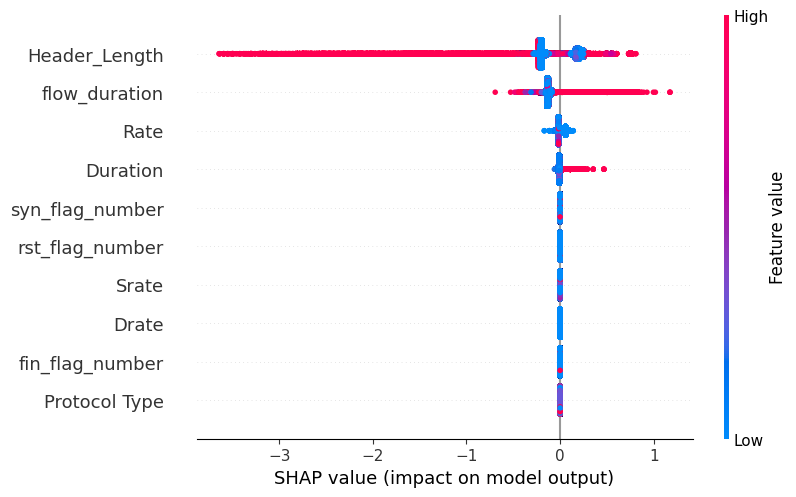

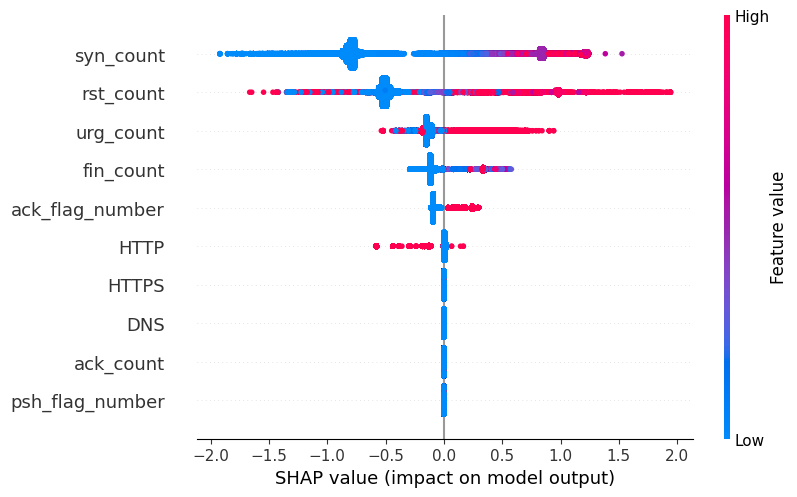

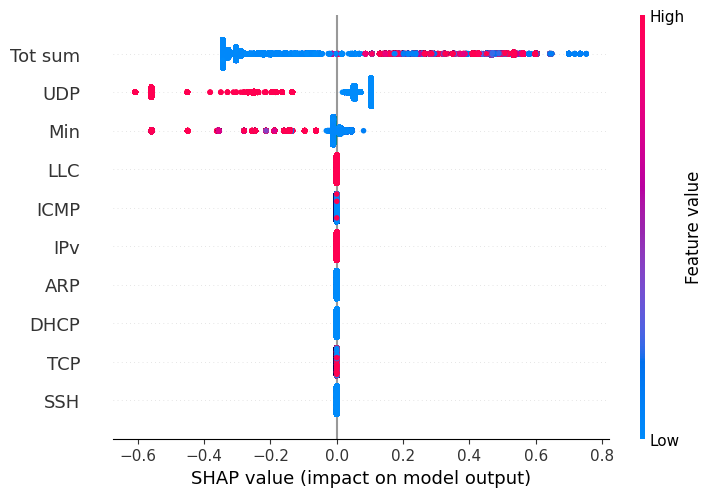

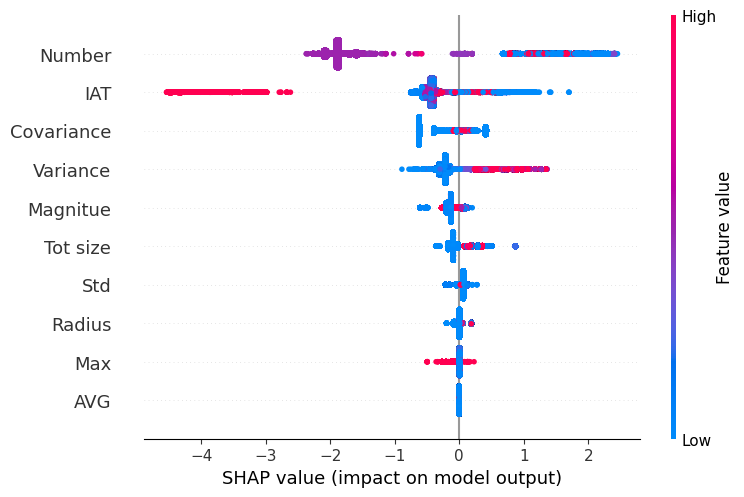

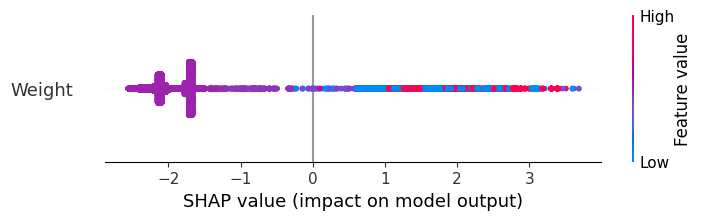

In [ ]:
#смотрим shap values для каждой фичи
for j in range(shap_values.shape[1] // 10 + 1):
  shap.plots.beeswarm(shap_values[:,(j*10):((j+1)*10)], group_remaining_features=False)

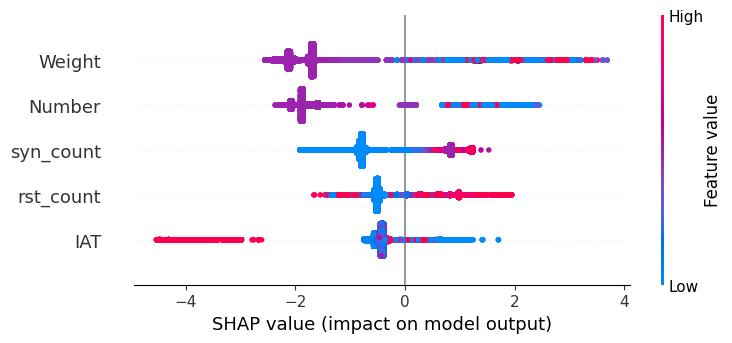

In [ ]:
import matplotlib.pyplot as plt
shap.initjs()

# Топ-5 признаков, характерных для Recon-атак
top_5_features = ["Weight", "Number", "syn_count", "rst_count", "IAT"]

# --- 1. Глобальный анализ: beeswarm-график ---
shap_top5 = shap_values[:, top_5_features]
shap.plots.beeswarm(shap_top5, max_display=5, show=True)

# # --- 2. Локальный анализ: waterfall-графики для 5 Recon-примеров ---
# # Найдём индексы первых 5 записей с меткой Recon (label=1)
# recon_indices = (y_test == 1).values.nonzero()[0][:5]

# # Строим waterfall-график для каждого примера
# for i, idx in enumerate(recon_indices):
#     print(f"\n Пример Recon-атаки #{i+1} (индекс {idx})")
#     shap.plots.waterfall(shap_values[idx, top_5_features], max_display=5)



## SHAP-анализ признаков

В ходе визуального анализа SHAP-графиков были выделены признаки, оказывающие наибольшее влияние на решение модели при распознавании атак типа Recon. Ниже приведено краткое описание этих признаков и их влияния.

### Важные признаки и их интерпретация:

1. **IAT (интервал между пакетами)**
  При низких значениях этого признака (то есть когда пакеты идут очень часто) модель склонна относить трафик к Recon-атакам. Это логично, так как разведка часто генерирует частые короткие пакеты.

2. **Weight**
  Признак с ярко выраженным положительным влиянием. Высокие значения напрямую ассоциируются с атакующим поведением. Возможно, это агрегированный показатель, встроенный в датасет.

3. **syn\_count**
  Малое количество SYN-флагов в соединении характерно для Recon. Это усиливает подозрение на атаку, и SHAP уводит решение в сторону положительного класса.

4. **Number (количество пакетов)**
  Модель учитывает общее число пакетов в сессии. Чем их меньше — тем выше вероятность, что это атака.

5. **rst\_count**
  Отсутствие RST-флагов (завершения соединения) — характерный признак Recon, особенно если сканирование быстрое и не требует закрытия соединений.



## Контрфактические примеры как атака на модель

Цель - сформировать искусственные примеры с минимальными изменениями этих признаков, чтобы ранее корректно классифицированные Recon-атаки модель больше не распознавала как Recon.

| Признак    | Модификация | Причина                      |
| ---------- | ----------- | ---------------------------- |
| Weight     | × 0.7       | Маскируем объём              |
| Number     | × 0.7       | Уменьшаем число пакетов      |
| syn\_count | → 0         | Удаляем признак сканирования |
| rst\_count | → 0         | Исключаем сбросы             |
| IAT        | × 0.5       | Сглаживаем интервалы         |

Эти изменения позволяют снизить значимость ключевых признаков, сохранив структуру атаки.


In [ ]:
# Выбираем 100 случайных Recon-примеров (метка = 1) из тестовой выборки
recon_samples = X_test[y_test == 1].copy()
recon_subset = recon_samples.sample(n=1000, random_state=42)

# Создаём контрфактические примеры с минимальными изменениями
cf_examples = recon_subset.copy()
cf_examples["Weight"] *= 0.7
cf_examples["Number"] *= 0.7
cf_examples["syn_count"] = 0
cf_examples["rst_count"] = 0
cf_examples["IAT"] *= 0.5

# Предсказываем на этих изменённых примерах
cf_preds = model.predict(cf_examples)

# Считаем, сколько примеров модель отнесла к классу "0" (не Recon)
num_cf = len(cf_preds)
num_misclassified = (cf_preds == 0).sum()
success_rate = num_misclassified / num_cf

print(f"Атака успешна: модель не распознала {num_misclassified} из {num_cf} Recon-примеров ({success_rate:.1%})")

# Объединяем изменённые и исходные данные для оценки итоговых метрик
X_attacked = pd.concat([X_test, cf_examples])
y_attacked = pd.concat([y_test, pd.Series([1]*num_cf, index=cf_examples.index)])

# Получаем предсказания и выводим новые метрики
y_pred_attacked = model.predict(X_attacked)
from sklearn.metrics import classification_report
print(classification_report(y_attacked, y_pred_attacked))



Атака успешна: модель не распознала 590 из 1000 Recon-примеров (59.0%)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    208288
           1       0.32      0.76      0.45      2427

    accuracy                           0.98    210715
   macro avg       0.66      0.87      0.72    210715
weighted avg       0.99      0.98      0.98    210715



Цель атаки достигнута: модель перестала распознавать 59% Recon-примеров.


| Метрика               | До атаки | После атаки |
| --------------------- | -------- | ----------- |
| F1-score (Recon)      | 0.43     | **0.45**    |
| Recall (Recon)        | 1.00     | **0.76**    |
| Balanced Accuracy     | 0.99     | **0.98**    |
| Weighted Avg Accuracy | 0.99     | **0.98**    |


Recall по классу Recon снизился с 1.00 до 0.76, что показывает: модель перестала обнаруживать часть атак.

Precision по классу Recon немного вырос (с 0.27 до 0.32), но это связано с тем, что модель теперь более избирательно помечает другую атаку как Recall.

Глобальные метрики (accuracy, weighted avg) изменились незначительно, так как атакующие примеры составляют лишь малую часть общей выборки.

Итог: атака была успешной — изменения в нескольких чувствительных признаках (например, Weight, syn_count, rst_count) привели к тому, что значительная часть Recon-атак стала невидимой для модели, несмотря на высокую общую точность (accuracy), обусловленную дисбалансом классов.